In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
# index = sys.path.index('')
# sys.path.pop(index)
path = sys.path[0]
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

for root, dirs, files in os.walk(parent_dir):
    for dir in dirs:
        sys.path.append(os.path.join(root, dir))

sys.path.append(parent_dir)
sys.path.pop(0)
print(sys.path)

['/Users/khatran/anaconda3/envs/quantum/lib/python3.11', '/Users/khatran/anaconda3/envs/quantum/lib/python3.11/lib-dynload', '', '/Users/khatran/anaconda3/envs/quantum/lib/python3.11/site-packages', '/Users/khatran/Documents/Research Work/Quantum Computing/GRAPE-for-qubit/experiments', '/Users/khatran/Documents/Research Work/Quantum Computing/GRAPE-for-qubit/output', '/Users/khatran/Documents/Research Work/Quantum Computing/GRAPE-for-qubit/quantum_optimal_control', '/Users/khatran/Documents/Research Work/Quantum Computing/GRAPE-for-qubit/.git', '/Users/khatran/Documents/Research Work/Quantum Computing/GRAPE-for-qubit/.vscode', '/Users/khatran/Documents/Research Work/Quantum Computing/GRAPE-for-qubit/experiments/x01_gate_lagos', '/Users/khatran/Documents/Research Work/Quantum Computing/GRAPE-for-qubit/output/x01_π', '/Users/khatran/Documents/Research Work/Quantum Computing/GRAPE-for-qubit/output/x01_90', '/Users/khatran/Documents/Research Work/Quantum Computing/GRAPE-for-qubit/output/x0

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import inspect

from quantum_optimal_control.helper_functions.grape_functions import *
from quantum_optimal_control.main_grape.grape import Grape

data_path = '../output/x01_π/'

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

# IBM Quantum channel; set to default
QiskitRuntimeService.save_account(channel='ibm_quantum', token="0574c8c9cfdbc7c47815e6d5db41423ab35fd457b628bfe1d64b6e9280175fe913a69f1b4c7cdebcdc38a1d843c4200c073954d9f21848cbf9df808b100d17cf", overwrite=True, set_as_default=True)

In [5]:
# To access saved credentials for the IBM cloud channel
# service = QiskitRuntimeService(channel="ibm_cloud")

# To access saved credentials for the IBM quantum channel
service = QiskitRuntimeService(channel="ibm_quantum")

In [6]:
# Specify the instance in service.backend() instead of initializing a new device
backend = service.backend("ibm_kyoto")

In [7]:
ns = 1.0e9
config = backend.configuration()
dt = config.dt
acquire_alignment = config.timing_constraints['acquire_alignment']
granularity = config.timing_constraints['granularity']
pulse_alignment = config.timing_constraints['pulse_alignment']
lcm = np.lcm(acquire_alignment, pulse_alignment)

In [8]:
def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

In [9]:
#Defining time scales

steps = 144 #1-2: 160
steps = get_closest_multiple_of_16(steps)
total_time = steps * dt * ns #ns dt = 0.2222222222

# Choose optimizing State transfer or Unitary gate
state_transfer = False

#Defining H0
qubit_state_num = 2 #change to 4
qubit_num = 1 
freq_ge = 0 #5.235350062289255 #GHz #change
g_ops = 0.073036776 #GHz #change
# 559352321.0160259

ens = np.array([2 * np.pi * ii * (freq_ge) for ii in np.arange(qubit_state_num)])
Q_x = np.diag(np.sqrt(np.arange(1, qubit_state_num)), 1) + np.diag(np.sqrt(np.arange(1, qubit_state_num)), -1)
Q_y = (0 + 1j) * (np.diag(np.sqrt(np.arange(1, qubit_state_num)), 1) - np.diag(np.sqrt(np.arange(1, qubit_state_num)), -1))
Q_z = np.diag(np.arange(0, qubit_state_num))
I_q = np.identity(qubit_state_num)
H_q = np.diag(ens)

H0 = H_q

#Defining Concerned states (starting states)
g = np.array([1,0])
e = np.array([0,1])
psi0 = [g,e]

#Defining states to include in the drawing of occupation
states_draw_list = [0,1]
states_draw_names = ['0','1']

#Defining U (Target)
target_vec_0 = np.zeros(qubit_state_num**qubit_num, dtype=complex)
target_vec_0[1] = 1

target_vec_1 = np.zeros(qubit_state_num**qubit_num, dtype=complex)
target_vec_1[0] = 0
    
U = [target_vec_0,target_vec_1]

#Defining U0 (Initial)
q_identity = np.identity(qubit_state_num**qubit_num)
U0 = q_identity

#Defining control Hs
XI = Q_x
YI = Q_y
ZI = Q_z
Hops = [XI]                                                                            
g_ops = 0.073036776 
ops_max_amp = [2 * np.pi * g_ops] # = Omega_{d, 0}
Hnames = ['x']

print(Hnames)

#Defining convergence parameters
max_iterations = 1000
decay = 5000 #max_iterations/2
convergence = {'rate': 0.1, 'update_step': 1, 'max_iterations': max_iterations, 'conv_target': 1e-6, 'learning_rate_decay': decay}

# guassian envelope pulse
reg_coeffs = {'envelope': 0.1, 'dwdt': 0.001}

['x']


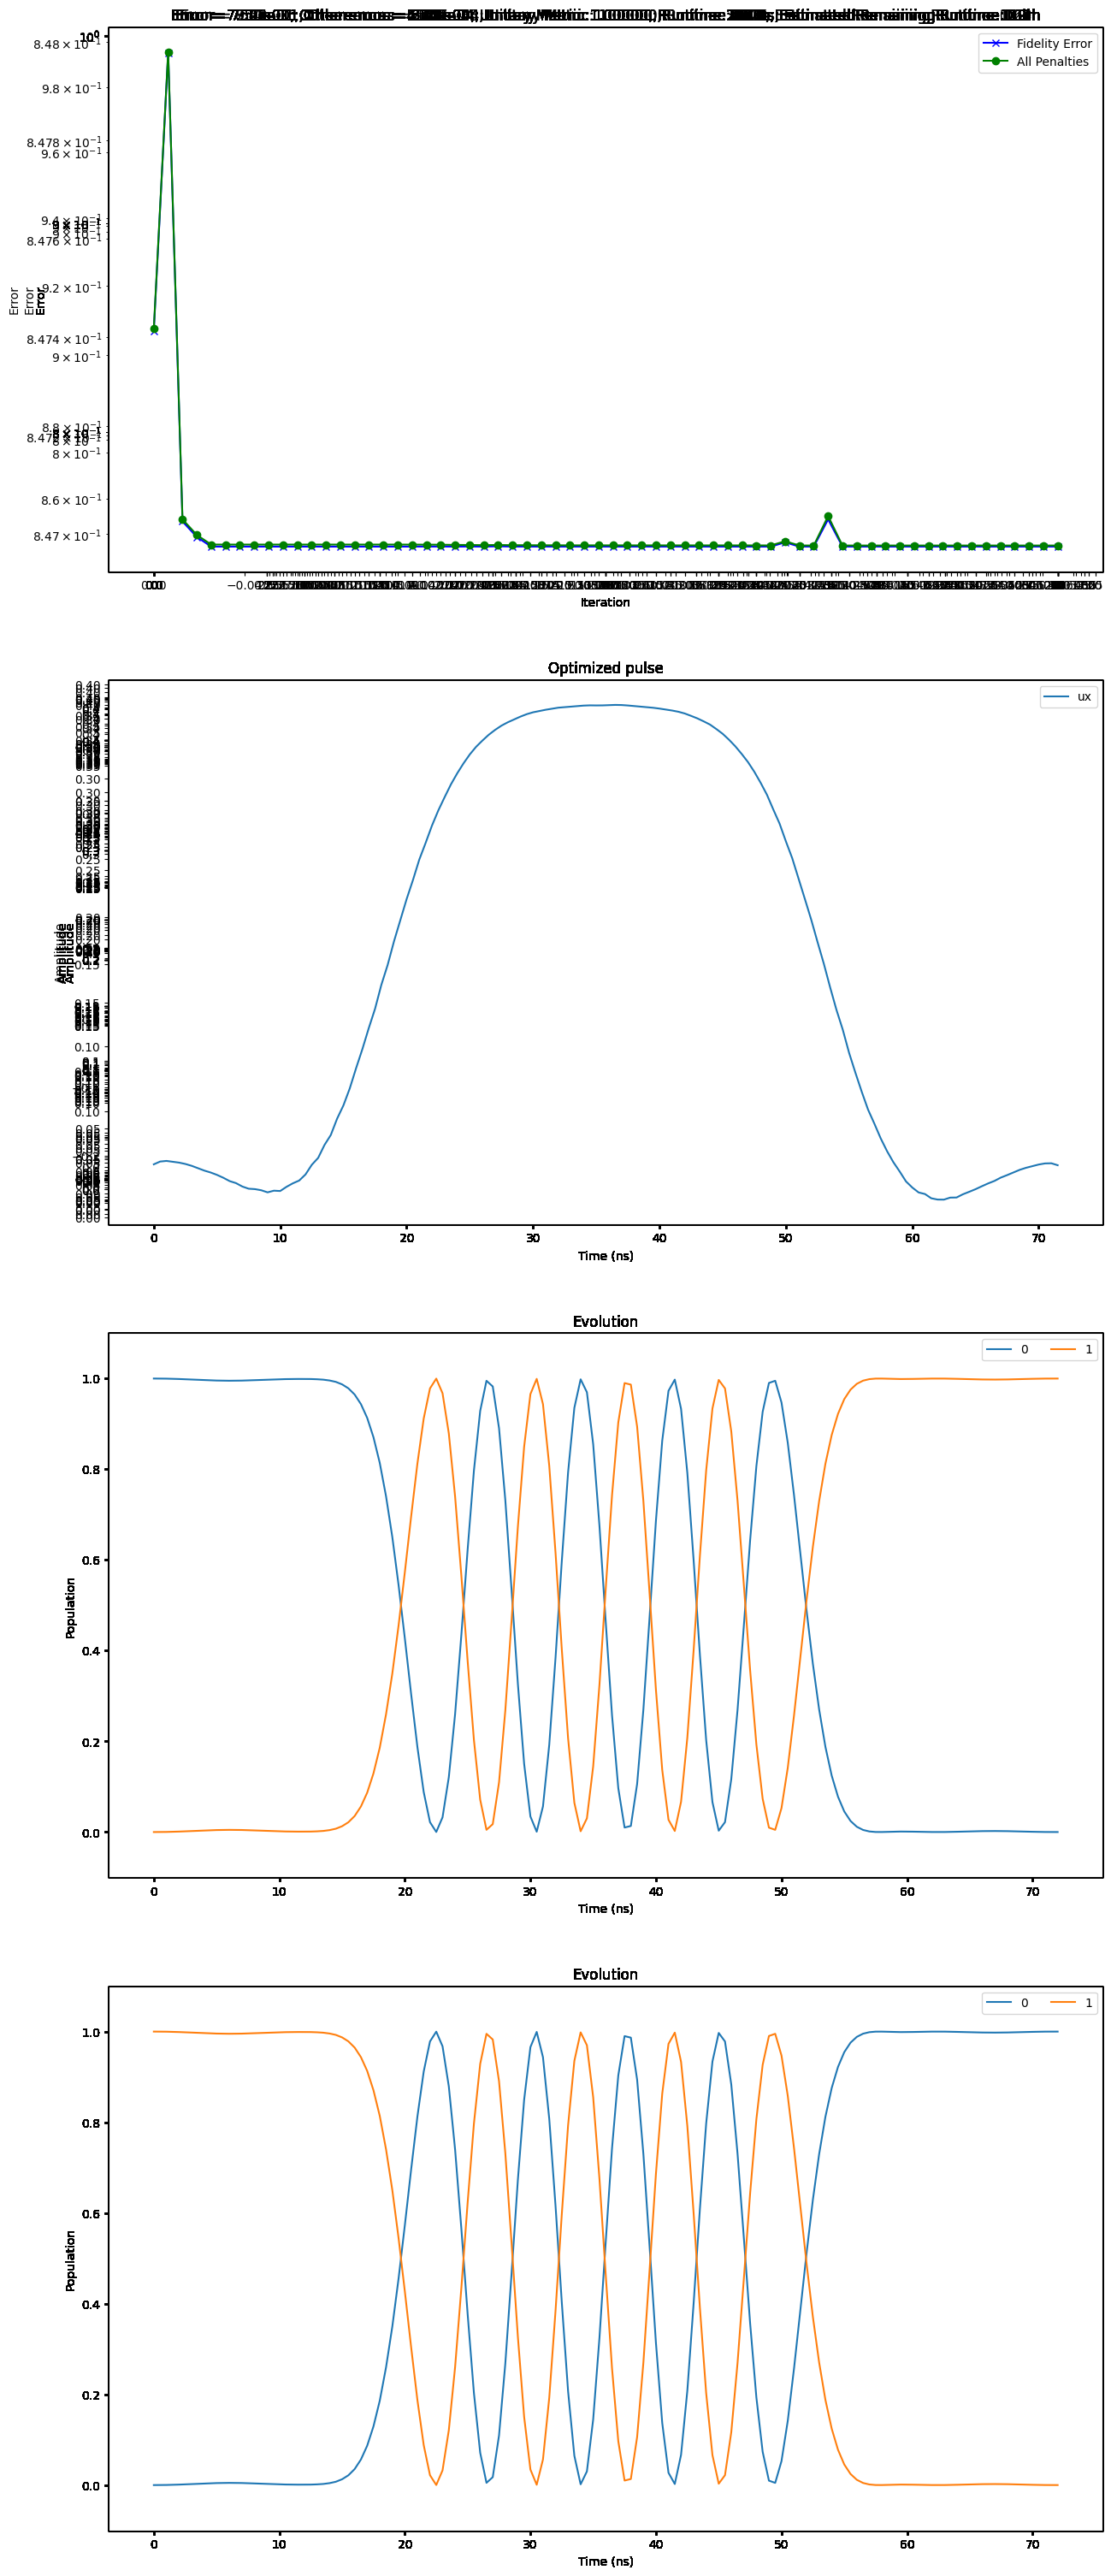

In [10]:
uks, U_final = Grape(H0, Hops, Hnames, U, total_time, steps, psi0,
                    convergence = convergence, 
                    draw = [states_draw_list, states_draw_names],
                    state_transfer = True,
                    use_gpu = False,
                    sparse_H = False,
                    show_plots = True, 
                    unitary_error = 1e-6, 
                    method = 'L-BFGS-B', 
                    maxA = ops_max_amp,
                    Taylor_terms = [20,0],
                    reg_coeffs = reg_coeffs,
                    save = True,
                    file_name = 'x01_lagos',
                    data_path = data_path)